# Import Libraries for Analyzing Sequences


In [4]:
import pysam
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd

# Read the Records for Chr 1 and 2 and Both Plasmids

In [5]:
def read_reference_records(filename):
    records = []
    with open(filename, "r") as reference_file:
        for record in SeqIO.parse(reference_file, "fasta"):
            records.append(record)
    return records
            
records = read_reference_records("ref1.fna")

# Read the Alignment Positions from the Parsed SAM File

In [6]:
def read_sam_hits(filename):
    hits = []
    with open(filename, "r") as sam_parsed:
        for line in sam_parsed:
            tokens = line.split()
            hits.append((tokens[0], int(tokens[1])-1))
    return hits

sam_hits = read_sam_hits("sam_parsed_final.txt")
        

# Compute the GC Content of the Sliding Windows

In [7]:
def get_sliding_window_metrics(records):
    results = []
    for record in records:
        window_start = 0
        str_seq = str(record.seq)
        str_seq_len = len(str_seq)
        while window_start < str_seq_len:
            gc_content = GC(str_seq[window_start:min(window_start+100, str_seq_len)])
            results.append([record.id, (window_start, window_start + 99), gc_content])
            window_start += 100
    return results

results = get_sliding_window_metrics(records)
        


In [8]:
def get_hit_counts(sam_hits):
    hit_count_dict = {}
    for (hid, pos) in sam_hits:
        if not (hid, pos) in hit_count_dict.keys():
            hit_count_dict[(hid, pos)] = 1
        else:
            hit_count_dict[(hid, pos)] += 1
    return hit_count_dict

hit_count_dict = get_hit_counts(sam_hits)

In [9]:
def hit_counts_by_record(hit_count_dict):
    # records 19 and 20 represent the plasmids, which didn't have much coverage
    record_ids = ['NZ_CP009617.1', 'NZ_CP009618.1', 'NZ_CP009619.1', 'NZ_CP009620.1']
    record_counts = []
    for rid in record_ids:
        total = sum([count for ((faid, _), count) in hit_count_dict.items() if faid == rid])
        record_counts.append(total)
        
    return record_counts
print(hit_counts_by_record(hit_count_dict))

[2466549, 1265276, 0, 2613]


# Combine the Read Counts and Window Metrics into Final Results

In [10]:
def get_full_results(sliding_windows, hit_count_dict):
    results = []
    for window in sliding_windows:
        count = 0
        for i in range(window[1][0], window[1][1]+1):
            try:
                count += hit_count_dict[(window[0], i)]
            except Exception:
                None
        results.append(window + [count])
    return results

chrm_ids = ['NZ_CP009617.1', 'NZ_CP009618.1']
filtered_windows = [result for result in results if result[0] in chrm_ids]
full_results = get_full_results(filtered_windows, hit_count_dict)

# Save Data to a Pandas DataFrame for Easy Analysis

In [11]:
df = pd.DataFrame(full_results, columns=["ID", "Window", "GC_Content", "Number of Reads"])


In [12]:
df["Number of Reads"].mean()

69.9131664730788

In [13]:
df.describe()

,GC_Content,Number of Reads
count,53378.000000,53378.000000
mean,45.525778,69.913166
std,5.780689,35.465932
min,12.000000,0.000000
25%,42.000000,62.000000
50%,46.000000,73.000000
75%,49.000000,84.000000
max,74.000000,2583.000000


# Generate Scatter Plot of GC Content vs. Number of Reads
_Here we check for any correlation between GC Content and number of reads across all windows_


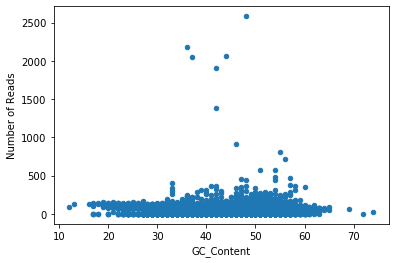

In [14]:
import matplotlib
df.plot.scatter("GC_Content", "Number of Reads")

# Filter outliers and Segregate Data into High and Low GC Content

In [15]:
df = df[df["Number of Reads"] <= 800]

In [16]:
high_gc = df[df["GC_Content"] >= 55.0]
low_gc = df[df["GC_Content"] <= 40.0]
low_gc.head(10)

,ID,Window,GC_Content,Number of Reads
0,NZ_CP009617.1,"(0, 99)",39.0,193
1,NZ_CP009617.1,"(100, 199)",35.0,119
2,NZ_CP009617.1,"(200, 299)",30.0,124
3,NZ_CP009617.1,"(300, 399)",36.0,99
26,NZ_CP009617.1,"(2600, 2699)",36.0,83
33,NZ_CP009617.1,"(3300, 3399)",40.0,85
35,NZ_CP009617.1,"(3500, 3599)",40.0,85
46,NZ_CP009617.1,"(4600, 4699)",36.0,78
47,NZ_CP009617.1,"(4700, 4799)",35.0,78
51,NZ_CP009617.1,"(5100, 5199)",40.0,66


In [17]:
high_gc.head(10)

,ID,Window,GC_Content,Number of Reads
17,NZ_CP009617.1,"(1700, 1799)",55.0,68
116,NZ_CP009617.1,"(11600, 11699)",57.0,90
121,NZ_CP009617.1,"(12100, 12199)",55.0,72
151,NZ_CP009617.1,"(15100, 15199)",55.0,80
181,NZ_CP009617.1,"(18100, 18199)",55.0,81
194,NZ_CP009617.1,"(19400, 19499)",55.0,81
200,NZ_CP009617.1,"(20000, 20099)",57.0,80
204,NZ_CP009617.1,"(20400, 20499)",56.0,50
208,NZ_CP009617.1,"(20800, 20899)",57.0,85
240,NZ_CP009617.1,"(24000, 24099)",56.0,69


In [18]:
len(low_gc)

9044

In [19]:
mean_high_hits = sum(list(high_gc["Number of Reads"])) / len(high_gc)
mean_low_hits = sum(list(low_gc["Number of Reads"])) / len(low_gc)

# Mean Number of Read Alignments for High GC vs. Low GC Windows

In [20]:
print(mean_high_hits)
print(mean_low_hits)

67.1867881548975
70.31932773109244


# Scatter Plots of GC Content vs. Hits for High and Low GC Data

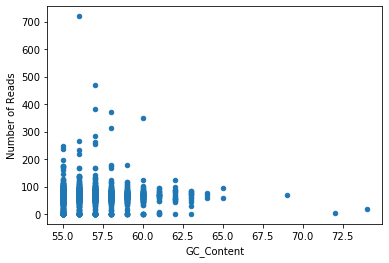

In [21]:
high_gc.plot.scatter("GC_Content", "Number of Reads")

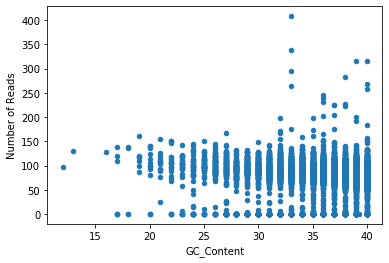

In [22]:
low_gc.plot.scatter("GC_Content", "Number of Reads")

# Histograms of GC Content Accross All Windows (Chr 1 and 2)
**Here we see that the distribution of hits by GC Content matches the distribution of GC Content in general across the entire genome. The reason there are few-to-no reads aligning at GC content windows above 60% is that there are simply very few windows of length 100 with such high GC content in this genome**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b5c4210>]],
      dtype=object)

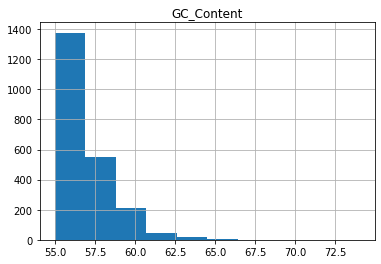

In [23]:
high_gc.hist("GC_Content")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b5c43d0>]],
      dtype=object)

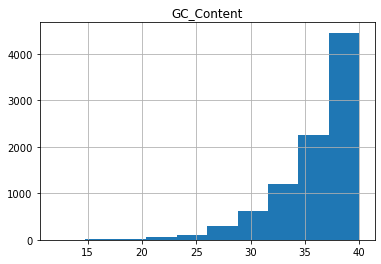

In [24]:
low_gc.hist("GC_Content")

# Compute a 2-Sample T-Test to Check for Significance
**Here we check to see if the difference in the mean number of reads in high gc vs low gc windows is significant with a 2 independent sample t-test**

In [25]:
from scipy.stats import ttest_ind
import numpy as np

ttest_ind(list(high_gc["Number of Reads"]), list(low_gc["Number of Reads"]), equal_var=False)

Ttest_indResult(statistic=-3.816242646713909, pvalue=0.00013773829487366665)

## Computing GC Content and Average Read Starts for IGV Highlighted Regions

In [26]:
region1 = df[(df["ID"] == 'NZ_CP009617.1') & (df["Window"].str[0] >= 742894) & (df["Window"].str[1] <= 743914)]

In [27]:
region2 = df[(df["ID"] == 'NZ_CP009617.1') & (df["Window"].str[0] >= 746902) & (df["Window"].str[1] <= 747998)]

In [28]:
region1.describe()

,GC_Content,Number of Reads
count,10.000000,10.000000
mean,40.300000,104.300000
std,7.789594,11.728882
min,30.000000,82.000000
25%,36.000000,97.750000
50%,38.000000,107.000000
75%,47.750000,111.250000
max,51.000000,118.000000


In [29]:
region2.describe()

,GC_Content,Number of Reads
count,9.000000,9.000000
mean,48.000000,43.333333
std,3.872983,7.071068
min,42.000000,29.000000
25%,45.000000,40.000000
50%,50.000000,45.000000
75%,51.000000,48.000000
max,52.000000,52.000000


In [30]:
print(GC(records[0].seq[604711:607869]))
print(GC(records[0].seq[742894:743914]))
print(GC(records[0].seq[746902:747998]))
print(GC(records[0].seq[2662091:2662410]))
print(GC(records[0].seq[27933:28161]))

44.96516782773907
40.294117647058826
47.71897810218978
50.78369905956113
35.526315789473685


# Show the Stats from the original SAM File

In [31]:
def samfile_stats(samfile):
    samfile = pysam.AlignmentFile(samfile, "r")
    iter = samfile.fetch()
    total = 0
    non_neg_pos = 0
    ref_regions = []
    no_hits = []
    pos = []
    for x in iter:
        total += 1
        if x.reference_start > -1:
            ref_regions.append(x.reference_id)
            pos.append(x.reference_start)
            non_neg_pos += 1
        else:
            no_hits.append(x.reference_id)
    
    print("ALIGNMENT RATE: ", non_neg_pos / total)
    print("REGIONS: ", set(ref_regions))
    print("NO HIT REGIONS: ", set(no_hits))
    
    return pd.DataFrame({"REGIONS":  ref_regions, "POSITION": pos})

In [33]:
# Alignment results from seed length of 19
sam_df = samfile_stats("bowtie_align_vs_L15.sam")

ALIGNMENT RATE:  0.7911071680435274
REGIONS:  {0, 1, 2}
NO HIT REGIONS:  {-1}


In [34]:
df.to_csv("sliding_window_metrics.tsv", sep="\t")